<a href="https://colab.research.google.com/github/kworathur/CV-Capstone/blob/main/brain_tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"keshavworathur","key":"525a7f6c30bb7e288d40bf6600c4074c"}'}

# Install Python packages and download dataset

In [ ]:
!pip install tensorflow
!pip install mat73
!pip install hdf5storage
!pip install opencv-python
!pip install gdown
!pip install -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

# Create the directories for original data
!rm -rf ./dataset/
!kaggle datasets download -d ashkhagan/figshare-brain-tumor-dataset
!unzip figshare-brain-tumor-dataset.zip > /dev/null



mv: cannot stat 'kaggle.json': No such file or directory
figshare-brain-tumor-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Download helper script hosted in google drive
!gdown https://drive.google.com/uc?id=1RFcC9qAiBl5Bv07wRD6HGRk_BBi1lU98


Downloading...
From: https://drive.google.com/uc?id=1RFcC9qAiBl5Bv07wRD6HGRk_BBi1lU98
To: /content/matlab_to_numpy.py
100% 3.10k/3.10k [00:00<00:00, 11.7MB/s]


In [ ]:
%run -i 'matlab_to_numpy.py' ./dataset/

[3064/3064] images loaded: 100.0 %
labels: (3064,)
images: (3064, 512, 512)
masks: (3064, 512, 512)
labels.npy, images.npy, masks.npy, patient_ids saved in ./dataset/


# Import Python Modules

In [ ]:
import os
from PIL import Image
from mat73 import loadmat

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# to perform subject-wise cross validation
from sklearn.model_selection import GroupKFold
import cv2

# Data Visualization




*   Class distribution
*   2D images with tumor slices
*   Different types of brain tumors: glioma, meningioma, pituitary





In [ ]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

## Load images, masks and labels

In [ ]:
labels = np.load('./dataset/labels.npy')
images = np.load('./dataset/images.npy')
masks = np.load('./dataset/masks.npy')
patient_ids = np.load('./dataset/patient_ids.npy').flatten()
file_paths = np.load('./dataset/file_paths.npy')

print(labels.shape)
print(images.shape)
print(masks.shape)
print(patient_ids.shape)

(3064,)
(3064, 512, 512)
(3064, 512, 512)
(3064,)


## Number of examples per class

number of meningioma (1): 708
number of glioma (2): 1426
number of pituitary tumor (3): 930


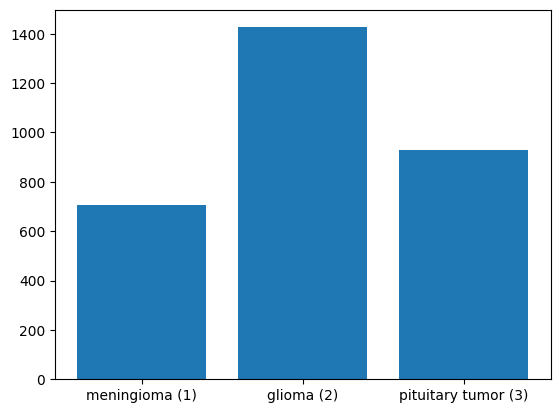

In [ ]:
classes, counts = np.unique(labels, return_counts=True)
plt.bar(classes, counts,
        tick_label=['meningioma (1)', 'glioma (2)', 'pituitary tumor (3)'])

for i, idx in enumerate(classes):
    print('number of {}: {}'.format(integer_to_class[str(idx)], counts[i]))

## Visualize slices with tumor masks

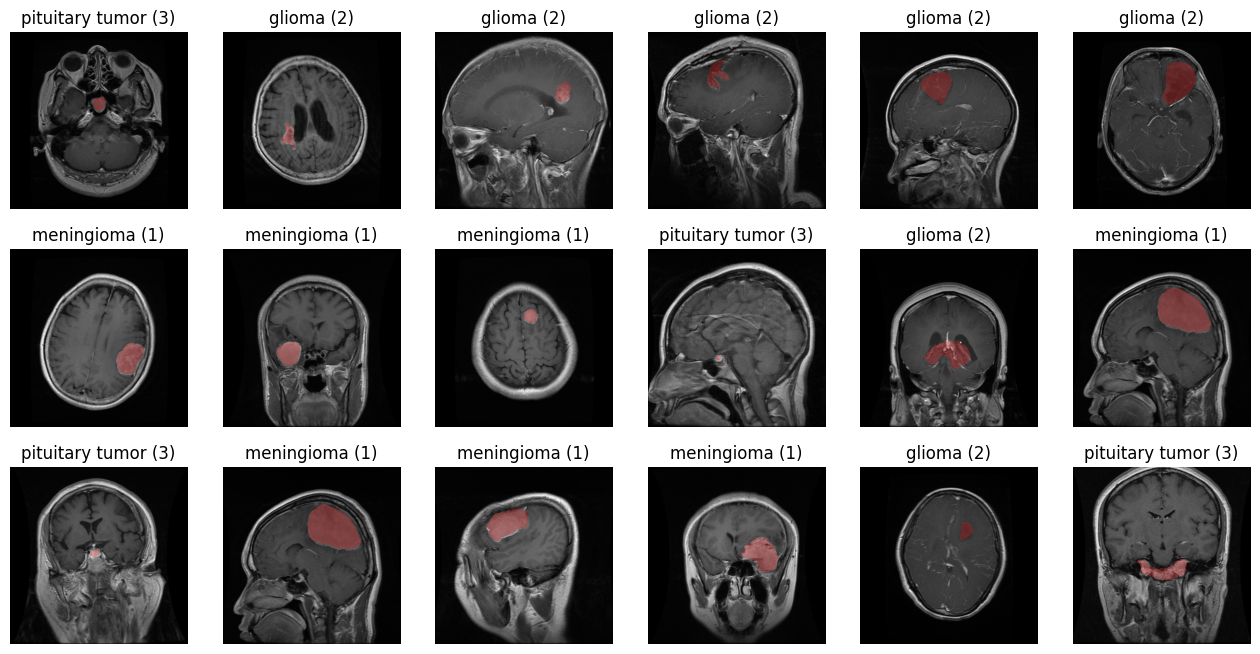

In [ ]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images[idx], cmap='gray')

    # set black pixel as transparent for the mask
    mask = np.ma.masked_where(masks[idx] == False, masks[idx])
    plt.imshow(mask, alpha=0.3, cmap='Set1')

    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

## Crop the images to the tumor region

In [ ]:
def get_bounding_box(mask):
    """
    Return the bounding box of a mask image.
    """
    xmin, ymin, xmax, ymax = 0, 0, 0, 0

    for row in range(mask.shape[0]):
        if mask[row, :].max() != 0:
            ymin = row
            break

    for row in range(mask.shape[0] - 1, -1, -1):
        if mask[row, :].max() != 0:
            ymax = row
            break

    for col in range(mask.shape[1]):
        if mask[:, col].max() != 0:
            xmin = col
            break

    for col in range(mask.shape[1] - 1, -1, -1):
        if mask[:, col].max() != 0:
            xmax = col
            break

    return xmin, ymin, xmax, ymax


def crop_to_bbox(image, bbox, crop_margin=10):
    """
    Crop an image to the bounding by forcing a squared image as output.
    """
    x1, y1, x2, y2 =  bbox

    # force a squared image
    max_width_height = np.maximum(y2 - y1, x2 - x1)
    y2 = y1 + max_width_height
    x2 = x1 + max_width_height

    # in case coordinates are out of image boundaries
    y1 = np.maximum(y1 - crop_margin, 0)
    y2 = np.minimum(y2 + crop_margin, image.shape[0])
    x1 = np.maximum(x1 - crop_margin, 0)
    x2 = np.minimum(x2 + crop_margin, image.shape[1])

    return image[y1:y2, x1:x2]

In [ ]:
from IPython.display import display, clear_output

dim_cropped_image = 224

images_cropped = []

for i in range(images.shape[0]):
    if i % 10 == 0:
        # print the pourcentage of images processed
        clear_output(wait=True)
        display('[{}/{}] images processed: {:.1f} %'
                .format(i+1, images.shape[0], (i+1) / images.shape[0] * 100))

    bbox = get_bounding_box(masks[i])
    image = crop_to_bbox(images[i], bbox, 20)
    image = cv2.resize(image, dsize=(dim_cropped_image, dim_cropped_image),
                       interpolation=cv2.INTER_CUBIC)
    images_cropped.append(image)

clear_output(wait=True)
display('[{}/{}] images processed: {:.1f} %'
        .format(i+1, images.shape[0], (i+1) / images.shape[0] * 100))

'[3064/3064] images processed: 100.0 %'

In [ ]:
images_cropped = np.array(images_cropped)

print(images_cropped.shape)

(3064, 224, 224)


## Visualize tumors

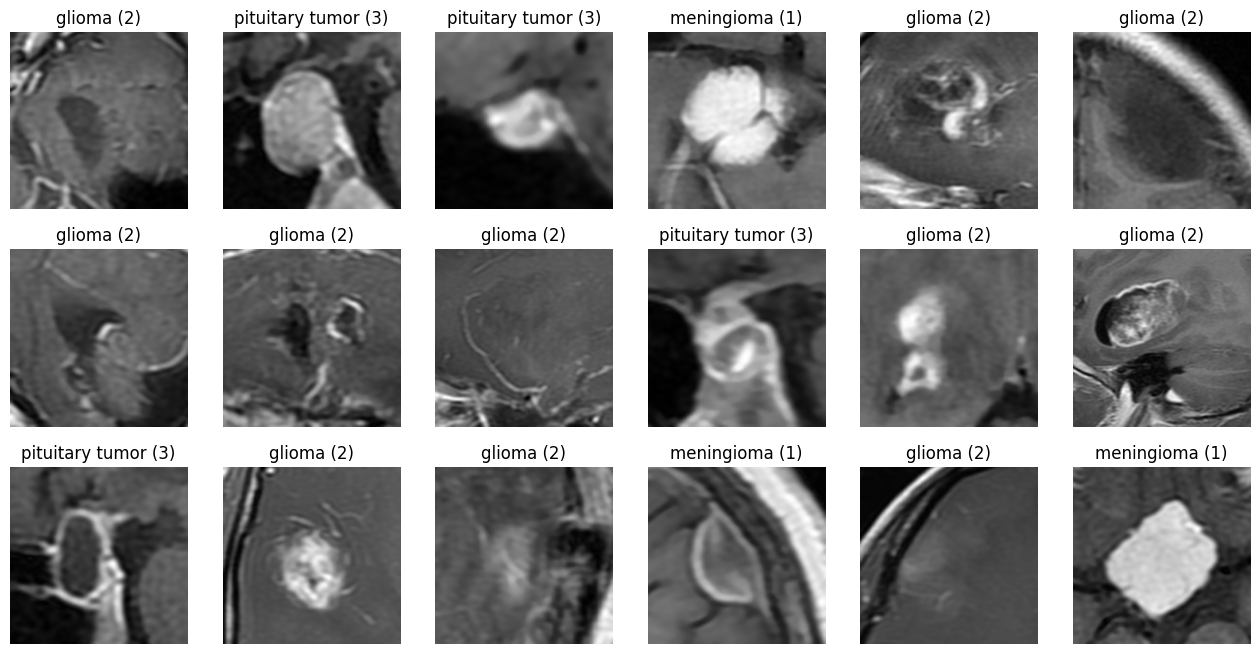

In [ ]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images_cropped[idx], cmap='gray')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

# Splitting the data using subject-wise cross validation

In [ ]:
# 10 fold cross validation. 6 folds used for training, 2 for validation, 2 for testing
group_kfold = GroupKFold(n_splits=10)

print(patient_ids)


print(f"Images {images.shape}")
print(labels.shape)
print(patient_ids.shape)

folds = [indices for (_, indices) in group_kfold.split(file_paths, labels, patient_ids)]

# 6 training, 2 validation, 2 test
train_indices, val_indices, test_indices = np.concatenate(folds[0:6]), np.concatenate(folds[6:8]), np.concatenate(folds[8:10])
train_data = tf.data.Dataset.from_tensor_slices((file_paths[train_indices], labels[train_indices]))
val_data = tf.data.Dataset.from_tensor_slices((file_paths[val_indices], labels[val_indices]))
test_data = tf.data.Dataset.from_tensor_slices((file_paths[test_indices], labels[test_indices]))



['103148' '106592' '102714' ... '113554' 'MR051644B' '101127']
Images (3064, 512, 512)
(3064,)
(3064,)


In [ ]:
# Configure dataset for performance
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
# Exact re-processing steps
resize_and_rescale = tf.keras.Sequential([
    keras.layers.Resizing(256, 256),
    keras.layers.Rescaling(1./255)
])

def preprocessing_layer(image_path):
  image = cv2.imread(image_path)
  image = resize_and_rescale(image)
  image = image.flatten() # Flatten to a 1D vector
  return image


image = cv2.imread(file_paths)


train_ds = train_data.map(lambda x, y: (preprocessing_layer(x), y))
val_ds = train_data.map(lambda x, y: (preprocessing_layer(x), y))
test_ds = train_data.map(lambda x, y: (preprocessing_layer(x), y))


model = keras.Sequential()
model.add(keras.Input(shape=(256, 256)))
### Classification Block A ###
model.add(keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'))


NameError: ignored

In [ ]:


# iterate over the input data, sorting by patient ID


# load into tensorflow data, apply normalization rescaling uniformly to all images

# Create a K-fold cross validation split

